In [1]:
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import scipy
from scipy import stats
# from adjustText import adjust_text
from Bio import SeqIO
from Bio.Seq import Seq
%matplotlib inline


%load_ext autoreload
%autoreload 2

# import gzip
# from cyvcf2 import VCF

from sklearn.linear_model import LinearRegression

from matplotlib import gridspec
from matplotlib.gridspec import GridSpec

from itertools import combinations
from ast import literal_eval

import sys
import os

home_dir = '~/Documents/Stanford/Research/EvolvingFront/'
home_dir = os.path.expanduser(home_dir)

tools_path = f'{home_dir}/code/processing/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()



In [2]:
merged_fitness = p.read_csv(f'{home_dir}/data/fitness_withMutations.csv',index_col=0)



In [3]:
### Now that we've drawn that line, let's purge the Li2019 mutants from the list


merged_fitness = merged_fitness[~merged_fitness['source_publication'].isin(['Li2019'])]

In [ ]:
merged_fitnes

WT PearsonRResult(statistic=-0.4764671462971547, pvalue=2.3204213599373356e-11)
CYR1 PearsonRResult(statistic=0.10630904100214596, pvalue=0.35108824208173595)
GPB2 PearsonRResult(statistic=-0.20348048051417816, pvalue=0.14794304534810676)
TOR1 PearsonRResult(statistic=-0.1525164593271835, pvalue=0.14007431017055305)
IRA1_MIS PearsonRResult(statistic=-0.41303602204260126, pvalue=0.00012703478743690216)
IRA1_NON PearsonRResult(statistic=-0.05564032433726551, pvalue=0.5922691387104213)


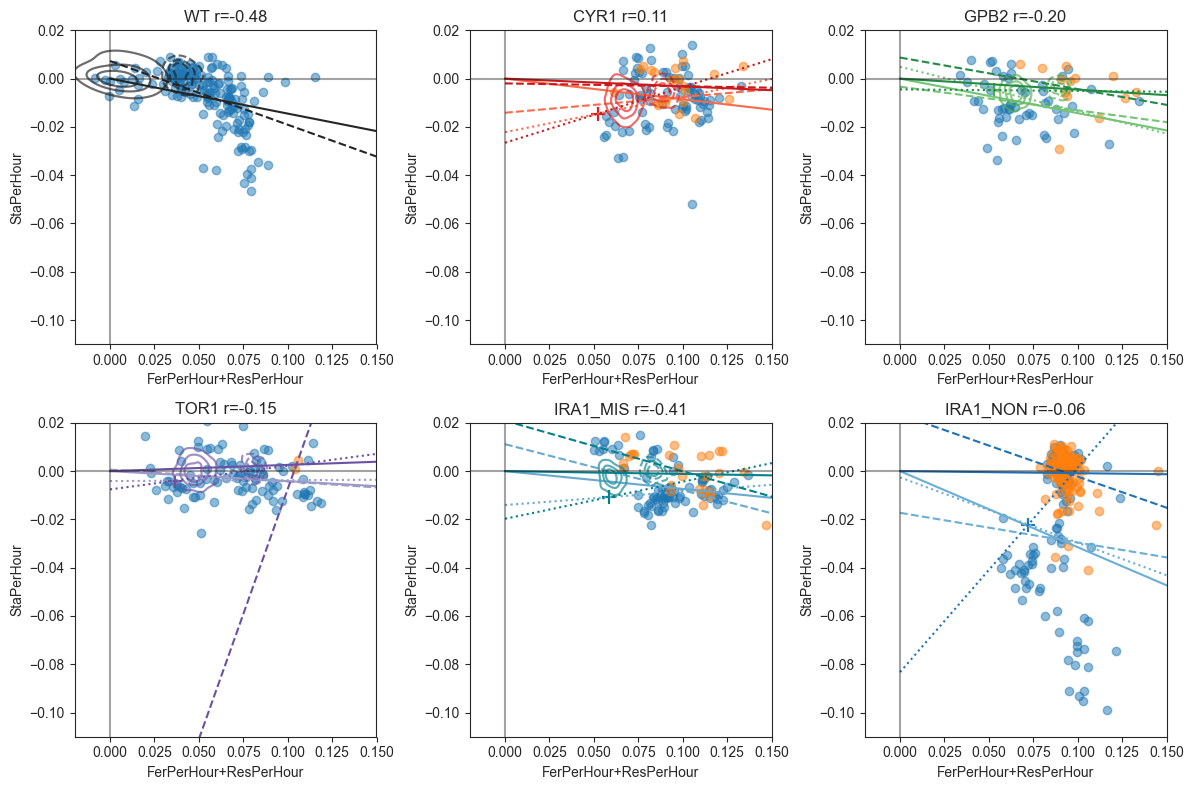

In [5]:
evo_cond_list = ['Evo2D','Evo3D']

ancestor_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']

merged_fitness['FerPerHour+ResPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['ResPerHour'] 

xdata = 'FerPerHour+ResPerHour'
ydata = 'StaPerHour'




plt.figure(figsize=(12,8))
for a,anc in enumerate(ancestor_list):
    
    plt.subplot(2,3,a+1)
    
    this_anc = merged_fitness[merged_fitness['ancestor']==anc]
    for evo_cond in evo_cond_list:
    
        this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

        sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

        this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

        sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        
        if evo_cond == 'Evo2D':
            print(anc,scipy.stats.pearsonr(this_data[xdata].values,this_data[ydata].values))
            plt.title(f'{anc} r={np.corrcoef(this_data[xdata].values,this_data[ydata].values)[0,1]:.2f}')
        
        
        plt.scatter(this_data[xdata].values,this_data[ydata].values,alpha=0.5)
#         plt.scatter(this_data['Fit2D_both2%5%_fitness'].values,this_data['StaPerHour'].values)
        
        if len(this_data[xdata].values) > 0:
            reg = LinearRegression(fit_intercept = False).fit(this_data[xdata].values.reshape(-1, 1),this_data['StaPerHour'].values)

            xs = np.linspace(0,3,100)
            plt.plot(xs,reg.coef_*xs+reg.intercept_,color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
            reg2 = LinearRegression().fit(this_data[xdata].values.reshape(-1, 1),this_data[ydata].values)

            xs = np.linspace(0,3,100)
            plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
            if anc != 'WT':
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]


                reg3 = LinearRegression(fit_intercept=False).fit((this_data[xdata].values-background_mutant[xdata].values).reshape(-1, 1)
                                              ,this_data[ydata].values-background_mutant[ydata].values)

                xs = np.linspace(0,3,100)
                plt.plot(xs,reg3.coef_*(xs-background_mutant[xdata].values)+(reg3.intercept_)+background_mutant[ydata].values,
                         ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])
#                 plt.plot(xs,reg3.coef_*(xs)+(reg3.intercept_)+background_mutant[ydata].values,
#                          ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])

        if anc != 'WT':
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

            plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[anc],s=100)
            
    
    plt.xlim(-0.02,0.15)
    plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
    
    plt.xlabel(xdata)
    plt.ylabel(ydata)
    
    plt.axhline(0,color='k',alpha=0.4)
    plt.axvline(0,color='k',alpha=0.4)
    
plt.tight_layout()

In [6]:
evo_cond_list = ['Evo2D','Evo3D']

ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]

merged_fitness['FerPerHour+ResPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['ResPerHour'] 

xdata = 'FerPerHour+ResPerHour'
ydata = 'Fit2D_early_fitness'


plt.figure(figsize=(12,8))
for a,ancs in enumerate(ancestor_list):
    
    i
    
    plt.subplot(2,3,a+1)
    
    this_anc = merged_fitness[merged_fitness['ancestor']==anc]
    for evo_cond in evo_cond_list:
    
        this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

        sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

        this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

        sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        
        if evo_cond == 'Evo2D':
            print(anc,scipy.stats.pearsonr(this_data[xdata].values,this_data[ydata].values))
            plt.title(f'{anc} r={np.corrcoef(this_data[xdata].values,this_data[ydata].values)[0,1]:.2f}')
        
        
        plt.scatter(this_data[xdata].values,this_data[ydata].values,alpha=0.5)
#         plt.scatter(this_data['Fit2D_both2%5%_fitness'].values,this_data['StaPerHour'].values)
        
#         if len(this_data[xdata].values) > 0:
#             reg = LinearRegression(fit_intercept = False).fit(this_data[xdata].values.reshape(-1, 1),this_data['StaPerHour'].values)

#             xs = np.linspace(0,3,100)
#             plt.plot(xs,reg.coef_*xs+reg.intercept_,color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
#             reg2 = LinearRegression().fit(this_data[xdata].values.reshape(-1, 1),this_data[ydata].values)

#             xs = np.linspace(0,3,100)
#             plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
#             if anc != 'WT':
#                 background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]


#                 reg3 = LinearRegression(fit_intercept=False).fit((this_data[xdata].values-background_mutant[xdata].values).reshape(-1, 1)
#                                               ,this_data[ydata].values-background_mutant[ydata].values)

#                 xs = np.linspace(0,3,100)
#                 plt.plot(xs,reg3.coef_*(xs-background_mutant[xdata].values)+(reg3.intercept_)+background_mutant[ydata].values,
#                          ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])
# #                 plt.plot(xs,reg3.coef_*(xs)+(reg3.intercept_)+background_mutant[ydata].values,
# #                          ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])

        if anc != 'WT':
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

            plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[anc],s=100)
            
    
    plt.xlim(-0.02,0.15)
    plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
    
    plt.xlabel(xdata)
    plt.ylabel(ydata)
    
    plt.axhline(0,color='k',alpha=0.4)
    plt.axvline(0,color='k',alpha=0.4)
    
plt.tight_layout()

NameError: name 'i' is not defined

<Figure size 864x576 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


WT
['Evo2D']
WT ['Evo2D'] -0.2637784548698465 0.0072905703924112724 2.320421359937063e-11
CYR1
['Evo2D']
CYR1 ['Evo2D'] 0.06509809560075247 -0.01413124051709844 0.3510882420817347
GPB2
['Evo2D']
GPB2 ['Evo2D'] -0.0976678974232018 -0.003360240158763823 0.14794304534810687
TOR1
['Evo2D']
TOR1 ['Evo2D'] -0.04921779626696503 0.0006239044498433598 0.1400743101705531
IRA1_MIS
['Evo2D']
IRA1_MIS ['Evo2D'] -0.1906805623059488 0.011163124129257584 0.00012703478743690164
IRA1_NON
['Evo2D']
IRA1_NON ['Evo2D'] -0.12303202954957554 -0.017270174549129977 0.5922691387104243


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CYR1
['Evo3D']
CYR1 ['Evo3D'] -0.011786047119216256 -0.0019803407521258054 0.904800234907039
GPB2
['Evo3D']
GPB2 ['Evo3D'] -0.13052908600703517 0.008723888815559595 0.4137381863992321
TOR1
['Evo3D']
TOR1 ['Evo3D'] 2.0705966798523314 -0.21452894312647386 0.0
IRA1_MIS
['Evo3D']
IRA1_MIS ['Evo3D'] -0.20945847262596165 0.020878016127811417 0.0031032224836190377
IRA1_NON
['Evo3D']
IRA1_NON ['Evo3D'] -0.2573192964571597 0.023455361697900245 0.0030405440905228705


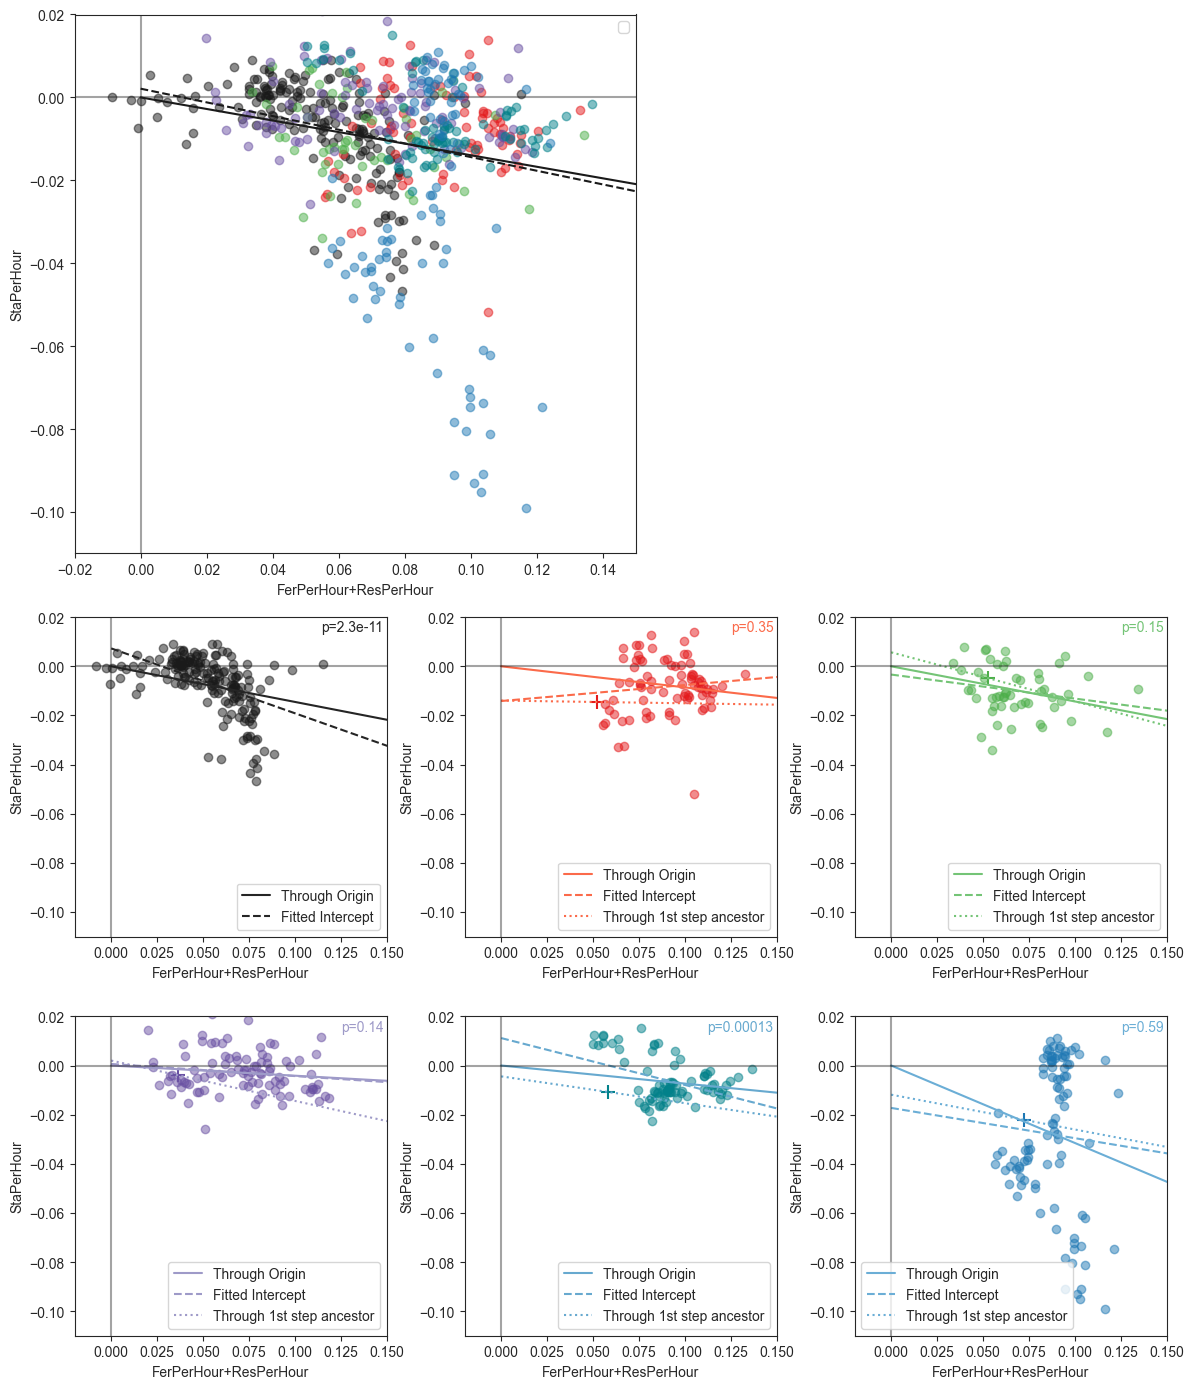

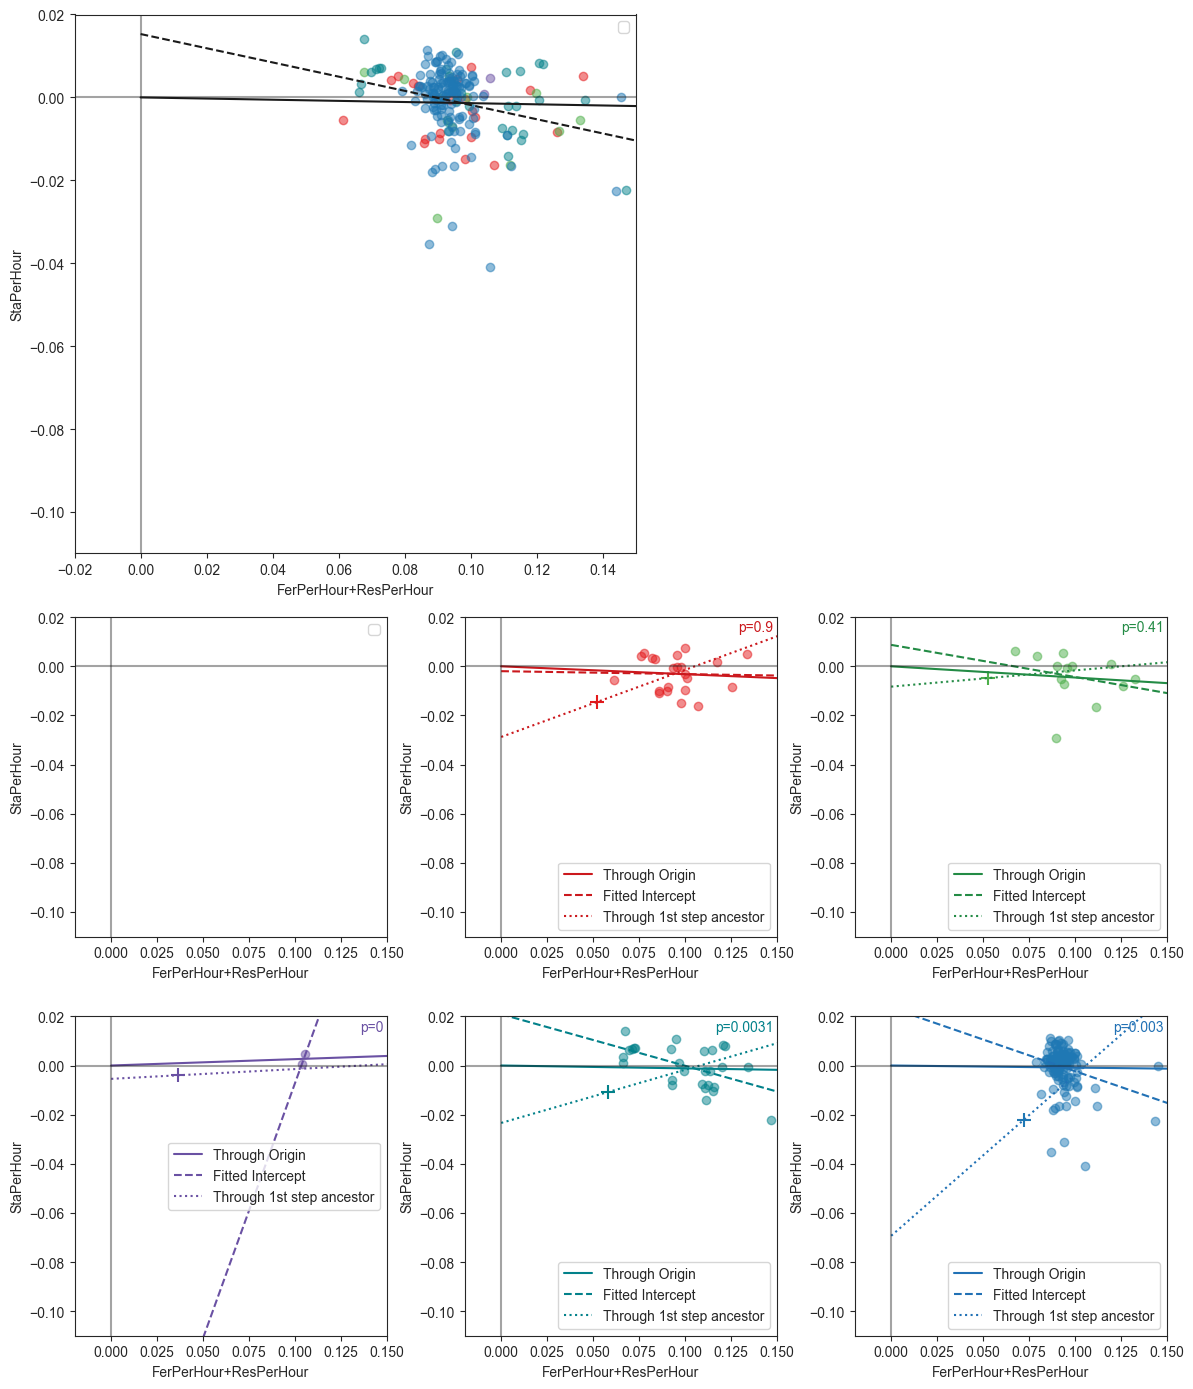

In [6]:

evo_cond_list = [['Evo2D'],['Evo3D'],['Evo2D','Evo3D']]
evo_cond_list = [['Evo2D'],['Evo3D']]
ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]

merged_fitness['FerPerHour+ResPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['ResPerHour'] 
xdata = 'FerPerHour+ResPerHour'
ydata = 'StaPerHour'

# merged_fitness['ResPerHour+StaPerHour'] = merged_fitness['ResPerHour'] + merged_fitness['StaPerHour'] 
# xdata = 'ResPerHour+StaPerHour'
# ydata = 'FerPerHour'

# merged_fitness['FerPerHour+StaPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['StaPerHour'] 
# xdata = 'FerPerHour+StaPerHour'
# ydata = 'ResPerHour'
                 
for evo_cond in evo_cond_list:
    fig = plt.figure(figsize=(12,14))
    outer_gs = gridspec.GridSpec(2, 1,height_ratios=[6,8])

    inner_gs1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[0],width_ratios=[6,2,2],wspace=0.25,hspace=0.25)
    inner_gs2 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)

    for a,ancs in enumerate(ancestor_list):
        
        if len(ancs) > 1:
            fig.add_subplot(inner_gs1[0]) 
        else:
            fig.add_subplot(inner_gs2[a-1])


        this_anc = merged_fitness

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
        this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]

        for anc in ancs:
            anc_here = this_data[this_data['ancestor']==anc]
            plt.scatter(anc_here[xdata].values,
                        anc_here[ydata].values,
                        alpha=0.5,color=tools.anc_color_map[anc])
            
            if len(anc_here[xdata].values) > 0 and len(ancs) == 1:
                print(anc)
                print(evo_cond)
                reg = LinearRegression(fit_intercept = False).fit(anc_here[xdata].values.reshape(-1, 1),anc_here[ydata].values)

                xs = np.linspace(0,3,100)
                plt.plot(xs,reg.coef_*xs+reg.intercept_,color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],label='Through Origin')
            
                reg2 = LinearRegression().fit(anc_here[xdata].values.reshape(-1, 1),anc_here[ydata].values)
                
                slope, intercept, r_value, p_value, std_err = stats.linregress(x=anc_here[xdata].values.reshape(-1, 1)[:,0],
                                                                               y=anc_here[ydata].values)
            
                print(anc,evo_cond,slope,intercept,p_value)
                plt.text(x=0.99,y=0.99,s=f'p={p_value:.2g}',transform=plt.gca().transAxes,
                         color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],ha='right',va='top')

                xs = np.linspace(0,3,100)
                plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],label='Fitted Intercept')
                
                if anc != 'WT':
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]


                    reg3 = LinearRegression(fit_intercept=False).fit((this_data[xdata].values-background_mutant[xdata].values).reshape(-1, 1)
                                                  ,this_data[ydata].values-background_mutant[ydata].values)

                    xs = np.linspace(0,3,100)
                    plt.plot(xs,reg3.coef_*(xs-background_mutant[xdata].values)+(reg3.intercept_)+background_mutant[ydata].values,
                             ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],label='Through 1st step ancestor')
    #                 plt.plot(xs,reg3.coef_*(xs)+(reg3.intercept_)+background_mutant[ydata].values,
    #                          ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])
             
        if len(ancs) > 1:

            reg = LinearRegression(fit_intercept = False).fit(this_data[xdata].values.reshape(-1, 1),this_data['StaPerHour'].values)

            xs = np.linspace(0,0.15,100)
            plt.plot(xs,reg.coef_*xs+reg.intercept_,color='k')

            reg2 = LinearRegression().fit(this_data[xdata].values.reshape(-1, 1),this_data[ydata].values)

            xs = np.linspace(0,0.15,100)
            plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color='k')
            

            
            
        elif ancs != ['WT']:
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[ancs[0]]]

            plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[ancs[0]],s=100)
            
    

        plt.xlim(-0.02,0.15)
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(xdata)
        plt.ylabel(ydata)
        plt.legend()

        plt.axhline(0,color='k',alpha=0.4)
        plt.axvline(0,color='k',alpha=0.4)

    plt.tight_layout()
                 
    plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/{xdata}v{ydata}_all{evo_cond}.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/{xdata}v{ydata}_all{evo_cond}.png',bbox_inches='tight',dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Evo2D'] CYR1 0.13350112695698552
['Evo2D'] GPB2 0.21126096730825322
['Evo2D'] TOR1 0.11672536358977097
['Evo2D'] IRA1_MIS 0.41381111168621476
['Evo2D'] IRA1_NON 9.12731390801522e-05
['Evo2D'] WT 0.04858462490618128
['Evo2D'] CYR1 0.13350112695698552
['Evo2D'] GPB2 0.21126096730825322
['Evo2D'] TOR1 0.11672536358977097
['Evo2D'] IRA1_MIS 0.41381111168621476


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Evo2D'] IRA1_NON 9.12731390801522e-05


/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_86193/3725726918.py:85: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = scipy.stats.ttest_ind(anc_here[ydata].values[double_improvers[0]],anc_here[ydata].values[slackers],equal_var=False)
/Users/grantkinsler/Documents/Stanford/Research/EvolvingFront/EvolvingFront-venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/grantkinsler/Documents/Stanford/Research/EvolvingFront/EvolvingFront-venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1250: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
No artists with labels found to put in legend.  Note that artists whose label start with an

['Evo3D'] CYR1 0.1869720362333654
['Evo3D'] GPB2 nan
['Evo3D'] TOR1 nan
['Evo3D'] IRA1_MIS 0.0688290369241987
['Evo3D'] IRA1_NON nan
['Evo3D'] WT nan
['Evo3D'] CYR1 0.1869720362333654
['Evo3D'] GPB2 nan
['Evo3D'] TOR1 nan
['Evo3D'] IRA1_MIS 0.0688290369241987
['Evo3D'] IRA1_NON nan


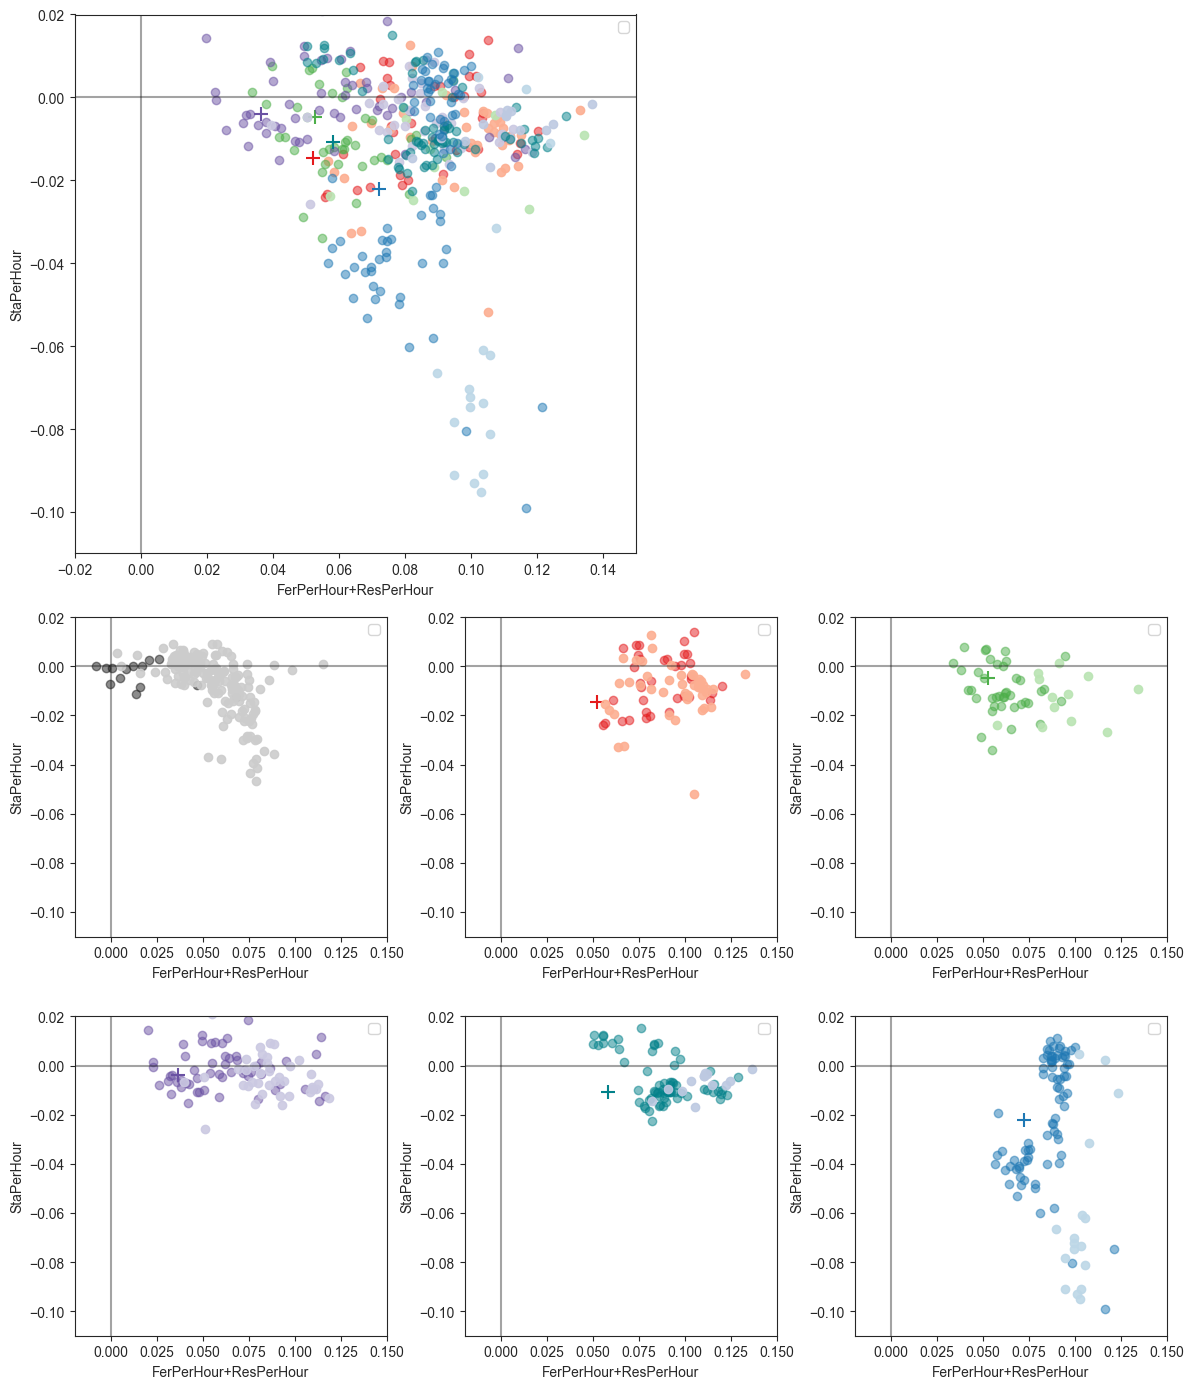

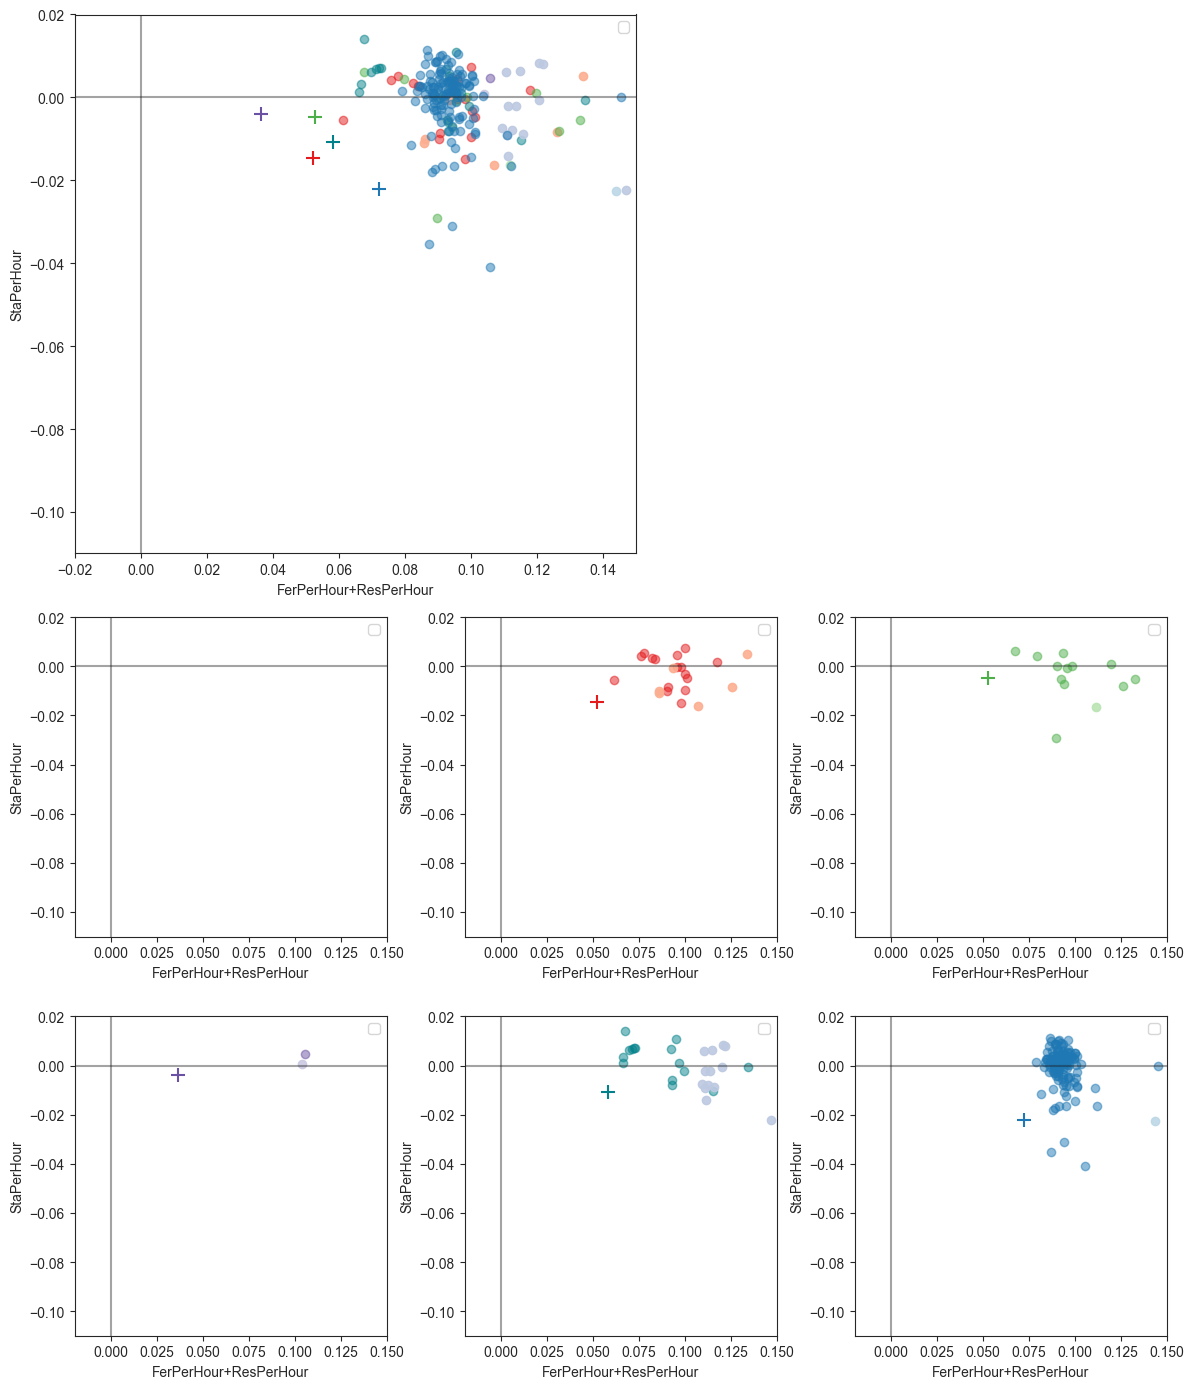

In [36]:
# do mutants that improve both fermentation and respiration have lower stationary performance?

evo_cond_list = [['Evo2D'],['Evo3D'],['Evo2D','Evo3D']]
evo_cond_list = [['Evo2D'],['Evo3D']]
ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]

ancestor_list = [['CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]



merged_fitness['FerPerHour+ResPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['ResPerHour'] 
xdata = 'FerPerHour+ResPerHour'
# xdata = 'Fit2D_early_fitness'
ydata = 'StaPerHour'

condition1='FerPerHour'
condition2='ResPerHour'


# merged_fitness['ResPerHour+StaPerHour'] = merged_fitness['ResPerHour'] + merged_fitness['StaPerHour'] 
# xdata = 'ResPerHour+StaPerHour'
# ydata = 'FerPerHour'

# merged_fitness['FerPerHour+StaPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['StaPerHour'] 
# xdata = 'FerPerHour+StaPerHour'
# ydata = 'ResPerHour'
                 
for evo_cond in evo_cond_list:
    fig = plt.figure(figsize=(12,14))
    outer_gs = gridspec.GridSpec(2, 1,height_ratios=[6,8])

    inner_gs1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[0],width_ratios=[6,2,2],wspace=0.25,hspace=0.25)
    inner_gs2 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)

    for a,ancs in enumerate(ancestor_list):
        
        if len(ancs) > 1:
            fig.add_subplot(inner_gs1[0]) 
        else:
            fig.add_subplot(inner_gs2[a-1])


        this_anc = merged_fitness

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
        this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]

        for anc in ancs:
            
            anc_here = this_data[this_data['ancestor']==anc]
            
            if anc != 'WT':
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]
                
                multiplier = 0
                
                double_improvers = np.where((anc_here[condition1].values > background_mutant[condition1].values+multiplier*background_mutant[condition1+'_error'].values) & 
                                            (anc_here[condition2].values > background_mutant[condition2].values+multiplier*background_mutant[condition2+'_error'].values))
                
                slackers = [ix for ix in range(len(anc_here[condition1].values)) if ix not in double_improvers[0]]
                
                plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[anc],s=100)
                
            else:
                double_improvers = np.where((anc_here[condition1].values > 0) & 
                                            (anc_here[condition2].values > 0))
                
                slackers = [ix for ix in range(len(anc_here[condition1].values)) if ix not in double_improvers[0]]
            
            plt.scatter(anc_here[xdata].values[slackers],
                        anc_here[ydata].values[slackers],
                        alpha=0.5,color=tools.anc_color_map[anc])
            
            plt.scatter(anc_here[xdata].values[double_improvers[0]],
                        anc_here[ydata].values[double_improvers[0]],
                        alpha=0.9,color=tools.anc_evo_cond_color_map[anc]['Evo1D'])
            
            ttest = scipy.stats.ttest_ind(anc_here[ydata].values[double_improvers[0]],anc_here[ydata].values[slackers],equal_var=False)
            print(evo_cond,anc,ttest.pvalue)
            


        plt.xlim(-0.02,0.15)
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(xdata)
        plt.ylabel(ydata)
        plt.legend()

        plt.axhline(0,color='k',alpha=0.4)
        plt.axvline(0,color='k',alpha=0.4)

    plt.tight_layout()
                 
    plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/{xdata}v{ydata}_all{evo_cond}.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/{xdata}v{ydata}_all{evo_cond}.png',bbox_inches='tight',dpi=300)

In [24]:
double_improvers

(array([0]),)

No handles with labels found to put in legend.


WT ['Evo2D'] -0.013108667009775723 -0.0065069156207110505 0.8778970437953183
CYR1 ['Evo2D'] 0.15273804157849744 -0.01212899447550404 0.043446759565620025
GPB2 ['Evo2D'] -0.1661979507839008 -0.008052496922342098 0.2743031476387782
TOR1 ['Evo2D'] -0.08046115605749148 -0.0016404047364665683 0.23719999576974415
IRA1_MIS ['Evo2D'] -0.1398628042665594 -0.0021151492690093246 0.12358382637607385
IRA1_NON ['Evo2D'] 1.04220836971806 -0.047635807951684705 0.005823689568556021


No handles with labels found to put in legend.
No handles with labels found to put in legend.


CYR1 ['Evo3D'] 0.1725051650367408 -0.010377249622859977 0.07912073964730285
GPB2 ['Evo3D'] 0.39284325263550296 -0.02028110566734835 0.022708691147230807
TOR1 ['Evo3D'] 0.4968258745228427 -0.012289194046834364 0.0
IRA1_MIS ['Evo3D'] 0.32344080957070426 -0.010720998571799424 0.00352282449109073
IRA1_NON ['Evo3D'] -0.2017563128421672 0.003280894583734798 0.04084498727733118


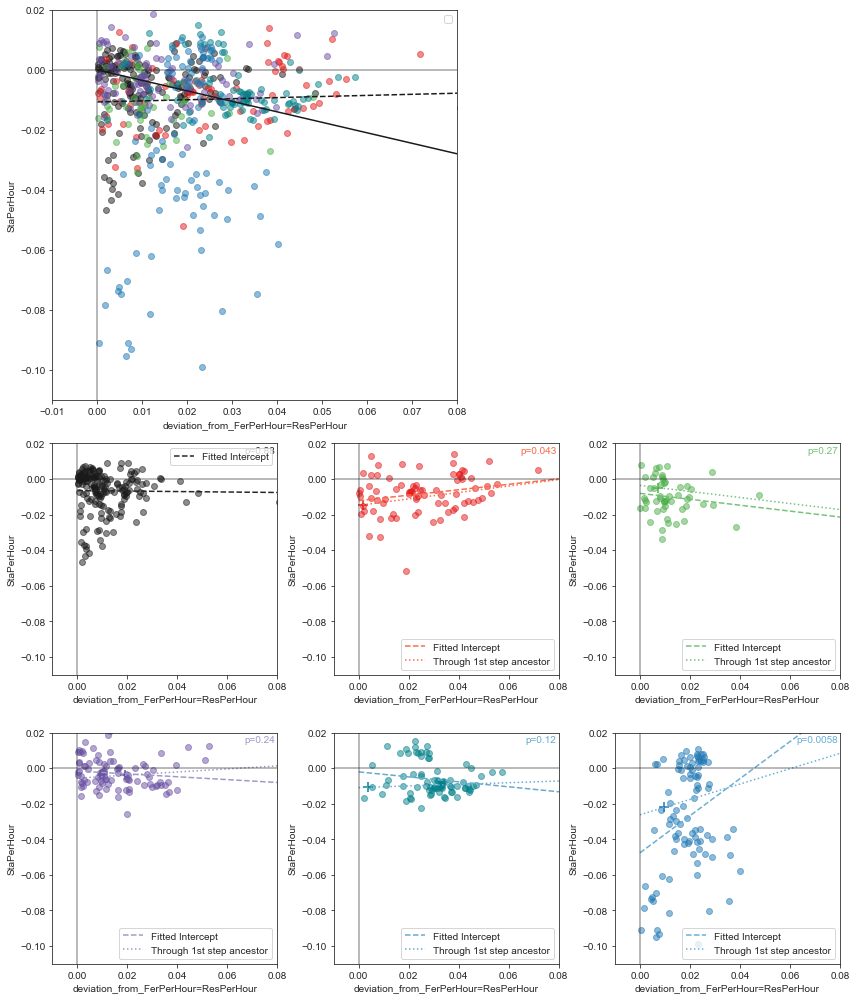

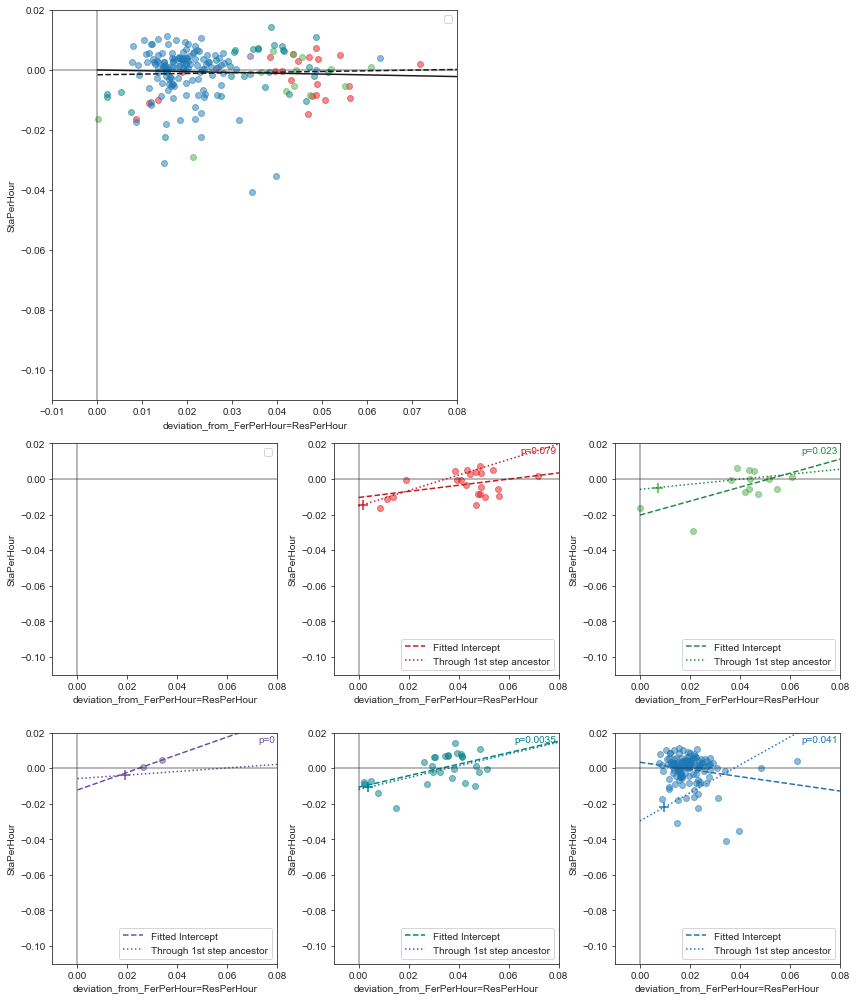

In [24]:

evo_cond_list = [['Evo2D'],['Evo3D'],['Evo2D','Evo3D']]
evo_cond_list = [['Evo2D'],['Evo3D']]
ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]

merged_fitness['FerPerHour+ResPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['ResPerHour'] 
xdata = 'FerPerHour+ResPerHour'
ydata = 'StaPerHour'

merged_fitness['deviation_from_FerPerHour=ResPerHour'] = np.abs(merged_fitness['ResPerHour']- merged_fitness['FerPerHour'])/np.sqrt(2)
xdata = 'deviation_from_FerPerHour=ResPerHour'
ydata = 'StaPerHour'

these_xlims = [-0.01,0.08]

# merged_fitness['ResPerHour+StaPerHour'] = merged_fitness['ResPerHour'] + merged_fitness['StaPerHour'] 
# xdata = 'ResPerHour+StaPerHour'
# ydata = 'FerPerHour'

# merged_fitness['FerPerHour+StaPerHour'] = merged_fitness['FerPerHour'] + merged_fitness['StaPerHour'] 
# xdata = 'FerPerHour+StaPerHour'
# ydata = 'ResPerHour'
                 
for evo_cond in evo_cond_list:
    fig = plt.figure(figsize=(12,14))
    outer_gs = gridspec.GridSpec(2, 1,height_ratios=[6,8])

    inner_gs1 = gridspec.GridSpecFromSubplotSpec(1,3,subplot_spec = outer_gs[0],width_ratios=[6,2,2],wspace=0.25,hspace=0.25)
    inner_gs2 = gridspec.GridSpecFromSubplotSpec(2,3,subplot_spec = outer_gs[1],wspace=0.25,hspace=0.25)

    for a,ancs in enumerate(ancestor_list):
        
        if len(ancs) > 1:
            fig.add_subplot(inner_gs1[0]) 
        else:
            fig.add_subplot(inner_gs2[a-1])


        this_anc = merged_fitness


#         this_pure_diploid = this_anc[(this_anc['ancestor'].isin(ancs)) & (this_anc['class_new']=='pure_diploids')]

#         sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
#                                 color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

#         this_neutral_haploid = this_anc[(this_anc['ancestor'].isin(ancs)) & (this_anc['class_new']=='neutral_haploids')]

#         sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
#                                 color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]
        this_data = interesting_muts[interesting_muts['evolution_condition'].isin(evo_cond)]

        for anc in ancs:
            anc_here = this_data[this_data['ancestor']==anc]
            plt.scatter(anc_here[xdata].values,
                        anc_here[ydata].values,
                        alpha=0.5,color=tools.anc_color_map[anc])
            
            if len(anc_here[xdata].values) > 0 and len(ancs) == 1:
#                 print(anc)
#                 print(evo_cond)
#                 reg = LinearRegression(fit_intercept = False).fit(anc_here[xdata].values.reshape(-1, 1),anc_here[ydata].values)

#                 xs = np.linspace(0,3,100)
#                 plt.plot(xs,reg.coef_*xs+reg.intercept_,color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],label='Through Origin')
            
                reg2 = LinearRegression().fit(anc_here[xdata].values.reshape(-1, 1),anc_here[ydata].values)

                xs = np.linspace(0,3,100)
                plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],label='Fitted Intercept')
                
                slope, intercept, r_value, p_value, std_err = stats.linregress(x=anc_here[xdata].values.reshape(-1, 1)[:,0],
                                                                               y=anc_here[ydata].values)
            
                print(anc,evo_cond,slope,intercept,p_value)
                plt.text(x=0.99,y=0.99,s=f'p={p_value:.2g}',transform=plt.gca().transAxes,
                         color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],ha='right',va='top')
                
                if anc != 'WT':
                    background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]


                    reg3 = LinearRegression(fit_intercept=False).fit((this_data[xdata].values-background_mutant[xdata].values).reshape(-1, 1)
                                                  ,this_data[ydata].values-background_mutant[ydata].values)

                    xs = np.linspace(0,3,100)
                    plt.plot(xs,reg3.coef_*(xs-background_mutant[xdata].values)+(reg3.intercept_)+background_mutant[ydata].values,
                             ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond[0]],label='Through 1st step ancestor')
    #                 plt.plot(xs,reg3.coef_*(xs)+(reg3.intercept_)+background_mutant[ydata].values,
    #                          ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])
             
        if len(ancs) > 1:

            reg = LinearRegression(fit_intercept = False).fit(this_data[xdata].values.reshape(-1, 1),this_data['StaPerHour'].values)

            xs = np.linspace(0,0.15,100)
            plt.plot(xs,reg.coef_*xs+reg.intercept_,color='k')

            reg2 = LinearRegression().fit(this_data[xdata].values.reshape(-1, 1),this_data[ydata].values)

            xs = np.linspace(0,0.15,100)
            plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color='k')
            
        elif ancs != ['WT']:
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[ancs[0]]]

            plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[ancs[0]],s=100)
            
    

        plt.xlim(these_xlims[0],these_xlims[1])
        plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])

        plt.xlabel(xdata)
        plt.ylabel(ydata)
        plt.legend()

        plt.axhline(0,color='k',alpha=0.4)
        plt.axvline(0,color='k',alpha=0.4)

    plt.tight_layout()
                 
    plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/{xdata}v{ydata}_all{evo_cond}.pdf',bbox_inches='tight')
    plt.savefig(f'{home_dir}/figures/analysis/stationary_effect/{xdata}v{ydata}_all{evo_cond}.png',bbox_inches='tight',dpi=300)

ValueError: Length of values (194) does not match length of index (1)

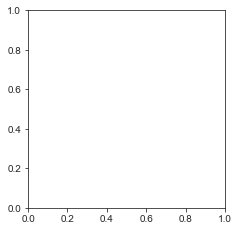

In [49]:
evo_cond_list = ['Evo2D','Evo3D']

ancestor_list = ['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON']

xdata = 'Fit2D_early_fitness'
ydata = 'StaPerHour'


plt.figure(figsize=(12,8))
for a,anc in enumerate(ancestor_list):
    
    plt.subplot(2,3,a+1)
    
    this_anc = merged_fitness[merged_fitness['ancestor']==anc]
    for evo_cond in evo_cond_list:
        
        if anc != 'WT':
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

#             plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
#                                     marker='+',color=tools.anc_color_map[anc],s=100)
            
        else:
            background_mutant = {}
            background_mutant[xdata] = [0]
            background_mutant[ydata] = [0]
            
            background_mutant = p.DataFrame(background_mutant)
            
#             plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
#                                     marker='+',color=tools.anc_color_map[anc],s=100)
            
    
        this_pure_diploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='pure_diploids')]

        sns.kdeplot(x=this_pure_diploid[xdata].values,
                    y=this_pure_diploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

        this_neutral_haploid = this_anc[(this_anc['ancestor']==anc) & (this_anc['class_new']=='neutral_haploids')]

        sns.kdeplot(x=this_neutral_haploid[xdata].values,
                    y=this_neutral_haploid[ydata].values,
                                color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)
        
        these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
        these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

        interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        

        plt.scatter(this_data[xdata].values-background_mutant[xdata].values[0],
                    this_data[ydata].values-background_mutant[ydata].values[0],
                    alpha=0.5)
#         plt.scatter(this_data['Fit2D_both2%5%_fitness'].values,this_data['StaPerHour'].values)
        
        if len(this_data[xdata].values) > 0:
            reg = LinearRegression(fit_intercept = False).fit((this_data[xdata].values-background_mutant[xdata]).reshape(-1, 1),
                                          this_data[ydata].values-background_mutant[ydata])

            xs = np.linspace(0,3,100)
            plt.plot(xs,reg.coef_*xs+reg.intercept_,color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
            reg2 = LinearRegression().fit((this_data[xdata].values-background_mutant[xdata]).reshape(-1, 1),
                                          this_data[ydata].values-background_mutant[ydata])

            xs = np.linspace(0,3,100)
            plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color='k')
        

            
    plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
    plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
    
    plt.xlabel(xdata)
    plt.ylabel(ydata)

In [48]:
p.DataFrame(background_mutant)

ValueError: If using all scalar values, you must pass an index

In [29]:
reg.score(this_data['Fit2D_early_fitness'].values.reshape(-1, 1),this_data['StaPerHour'].values)

0.05974196903802498

In [30]:
reg.coef_

array([-0.00951696])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

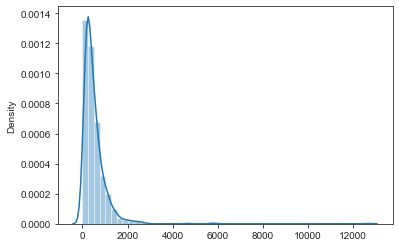

In [46]:
sns.distplot(merged_fitness[merged_fitness['source_publication']=='This_study']['Fit1D-2%-R1-T2'].values)

(0.0, 100.0)

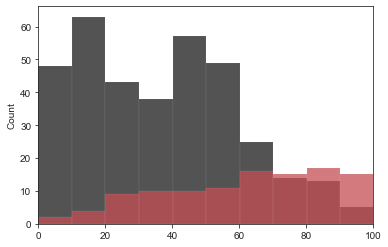

In [78]:
timepoint= 'Fit2D-2%-T0'
timepoint= 'Fit2D-2%-R1-T2'
plt.figure()
counts,bins = np.histogram(merged_fitness[merged_fitness['source_publication']=='This_study'][timepoint].values,
                          bins=np.linspace(0,5000,500))
sns.histplot(merged_fitness[merged_fitness['source_publication']=='Venkataram2015'][timepoint].values,color='k',bins=bins)
sns.histplot(merged_fitness[merged_fitness['source_publication']=='This_study'][timepoint].values,color='r',bins=bins)
plt.xlim(0,100)

In [92]:
timepoints = ['Fit2D-5%-T0','Fit2D-5%-R1-T2','Fit1D-5%-T0','Fit1D-5%-R1-T2']

count_threshold = 50

sum(np.all(merged_fitness[merged_fitness['source_publication']=='This_study'][timepoints].values < count_threshold,axis=1))

2

In [82]:
len(merged_fitness[merged_fitness['source_publication']=='This_study'].values)

1262

In [ ]:
evo_cond_list = ['Evo2D','Evo3D']

ancestor_list = [['WT','CYR1','GPB2','TOR1','IRA1_MIS','IRA1_NON'],['WT'],['CYR1'],['GPB2'],['TOR1'],['IRA1_MIS'],['IRA1_NON']]

xdata = 'Fit2D_early_fitness'
ydata = 'StaPerHour'


plt.figure(figsize=(12,8))
for a,anc_list in enumerate(ancestor_list):
    
    plt.subplot(2,3,a+1)
    
    this_anc = merged_fitness[merged_fitness['ancestor'].isin(anc_list)]
    for evo_cond in evo_cond_list:
        
        for anc in anc_list
    
            this_pure_diploid = this_anc[(this_anc['ancestor'].isin(anc)) & (this_anc['class_new']=='pure_diploids')]

            sns.kdeplot(x=this_pure_diploid[xdata].values,y=this_pure_diploid[ydata].values,
                                    color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4,linestyles='--')

            this_neutral_haploid = this_anc[(this_anc['ancestor'].isin(anc)) & (this_anc['class_new']=='neutral_haploids')]

            sns.kdeplot(x=this_neutral_haploid[xdata].values,y=this_neutral_haploid[ydata].values,
                                    color=tools.anc_color_map[anc],alpha=0.4,thresh=0.2,levels=4)

            these_pure_diploids = this_anc[this_anc['class_new']=='pure_diploids']['barcode'].values
            these_neutral_haploids = this_anc[this_anc['class_new']=='neutral_haploids']['barcode'].values

            interesting_muts = this_anc[~this_anc['barcode'].isin(list(these_neutral_haploids)+list(these_pure_diploids))]


        interesting_muts = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        this_data = interesting_muts[interesting_muts['evolution_condition']==evo_cond]
        
        
        if anc != 'WT':
            plt.scatter(this_data[xdata].values,this_data[ydata].values,alpha=0.3,
                        color=tools.anc_evo_cond_color_map[anc][evo_cond],marker=tools.evo_cond_marker_map[evo_cond])
        else:
            plt.scatter(this_data[xdata].values,this_data[ydata].values,alpha=0.3,color='k')
#         plt.scatter(this_data['Fit2D_both2%5%_fitness'].values,this_data['StaPerHour'].values)
        
        if len(this_data[xdata].values) > 0:
            reg = LinearRegression(fit_intercept = False).fit(this_data[xdata].values.reshape(-1, 1),this_data['StaPerHour'].values)

            xs = np.linspace(0,3,100)
            plt.plot(xs,reg.coef_*xs+reg.intercept_,color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
            reg2 = LinearRegression().fit(this_data[xdata].values.reshape(-1, 1),this_data[ydata].values)

            xs = np.linspace(0,3,100)
            plt.plot(xs,reg2.coef_*xs+reg2.intercept_,ls='--',color=tools.anc_evo_cond_color_map[anc][evo_cond])
            
            if anc != 'WT':
                background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]


                reg3 = LinearRegression(fit_intercept=False).fit((this_data[xdata].values-background_mutant[xdata].values).reshape(-1, 1)
                                              ,this_data[ydata].values-background_mutant[ydata].values)
                


                xs = np.linspace(0,3,100)
                plt.plot(xs,reg3.coef_*(xs-background_mutant[xdata].values)+(reg3.intercept_)+background_mutant[ydata].values,
                         ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])
#                 plt.plot(xs,reg3.coef_*(xs)+(reg3.intercept_)+background_mutant[ydata].values,
#                          ls=':',color=tools.anc_evo_cond_color_map[anc][evo_cond])

        if anc != 'WT':
            background_mutant = merged_fitness[merged_fitness['barcode']==tools.rebarcoding_source_mutants[anc]]

            plt.scatter(background_mutant[xdata].values,background_mutant[ydata].values,
                                    marker='+',color=tools.anc_color_map[anc],s=100)
            
    plt.xlim(tools.lims[xdata][0],tools.lims[xdata][1])
    plt.ylim(tools.lims[ydata][0],tools.lims[ydata][1])
    
    plt.xlabel(xdata)
    plt.ylabel(ydata)
plt.tight_layout()